<a href="https://colab.research.google.com/github/meronsyu/seccamp-submission/blob/main/datapollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.1 MB/s eta 0:00:00


In [8]:
# 必要なライブラリのインポート
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

# TensorFlowのインポート
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout

tf.compat.v1.disable_eager_execution()

# ARTのインポート
import art
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [9]:
# CIFAR10のロード
(X_train_origin, y_train_origin), (X_test_origin, y_test_origin, ) = tf.keras.datasets.cifar10.load_data()

# クラスの定義
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(classes)

170498071/170498071 [==============================] - 13s 0us/step


(50000, 32, 32, 3) (50000, 1)


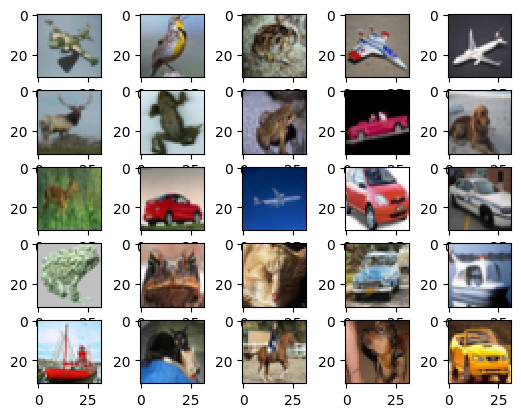

In [10]:
# データセットの可視化
show_images = []
for _ in range(5 * 5):
    show_images.append(X_train_origin[random.randint(0, len(X_train_origin))])

for idx, image in enumerate(show_images):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(image)

# 学習データ数、テストデータ数を表示
print(X_train_origin.shape, y_train_origin.shape)

In [11]:
# データセットの正規化
X_train = X_train_origin.astype("float32") / 255
X_test = X_test_origin.astype("float32") / 255

# ラベルをOne-hot-vector化
y_train = tf.keras.utils.to_categorical(y_train_origin, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_origin, num_classes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                             

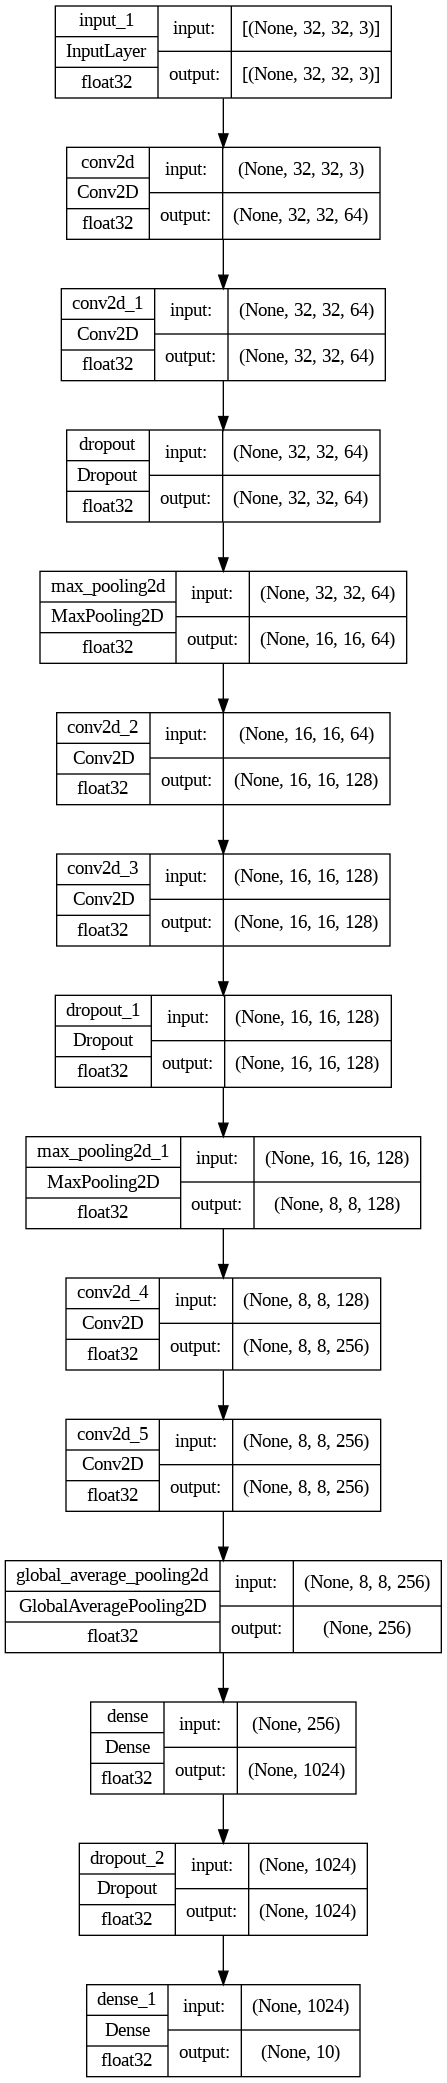

In [12]:
# アーキテクチャの定義
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding="SAME", activation="relu")(inputs)
x = Conv2D(64, (3, 3), padding="SAME", activation="relu")(x)
x = Dropout(0.25)(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding="SAME", activation="relu")(x)
x = Conv2D(128, (3, 3), padding="SAME", activation="relu")(x)
x = Dropout(0.25)(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding="SAME", activation="relu")(x)
x = Conv2D(256, (3, 3), padding="SAME", activation="relu")(x)
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
y = Dense(10, activation="softmax")(x)

model = Model(inputs, y)

# モデルのコンパイル
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_dtype=True, to_file="model.png")
#model.summaryは数値、tf.kerasは図がわかりやすく載せられる

In [13]:
# 入力データの特徴量の最小値・最大値を指定
# 特徴量は0.0～1.0の範囲に収まるように正規化しているため、最小値は0.0、最大値は1.0に設定
min_pixel = 0.0
max_pixel = 1.0

# 標的AIをARTのKerasClassifierでラップ
classifier = KerasClassifier(
    model=model, clip_values=(min_pixel, max_pixel), use_logits=False
)

In [14]:
classifier.fit(
    X_train,
    y_train,
    batch_size=128,
    nb_epochs=10,
    validation_data=(X_test, y_test),
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [15]:
# [2-4]
# 画像分類器の推論精度を評価
predictions = classifier.predict(X_test)
benign_accuracy = np.sum(
    np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)
) / len(y_test)
print("テストデータの推論精度: {}%".format(benign_accuracy * 100))

print("Done.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


テストデータの推論精度: 79.17%
Done.


In [16]:
# FGSMインスタンスの作成
attack_generic = FastGradientMethod(estimator=classifier, eps=1.50)

In [17]:
# 敵対的サンプルの生成（テストデータを基に作成する）
X_test_adv_non_target = attack_generic.generate(x=X_test)

In [18]:
# 敵対的サンプルを使用して標的AIの推論精度を評価
all_preds = classifier.predict(X_test_adv_non_target)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(
    y_test
)
print(
    "敵対的サンプルの推論精度: {}%（正常データ） -> {}%（敵対的サンプル）".format(
        benign_accuracy * 100, accuracy * 100
    )
)

敵対的サンプルの推論精度: 79.17%（正常データ） -> 10.38%（敵対的サンプル）


### 正常データの推論 ###
正解ラベル: "ship"
予測ラベル: "ship"


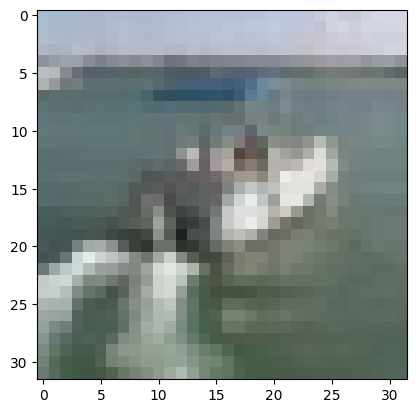

In [19]:
# 正常データの表示
target_index = random.randint(0, len(X_test) - 1)
plt.imshow(X_test[target_index])

# 正常データに対する推論
pred = classifier.predict(X_test[target_index][np.newaxis, ...])

# 推論結果の表示
print("### 正常データの推論 ###")
print(
    '正解ラベル: "{}"\n予測ラベル: "{}"'.format(
        classes[np.argmax(y_test[target_index])], classes[np.argmax(pred)]
    )
)

### 敵対的サンプルの推論 ###
正解ラベル: "ship"
予測ラベル: "truck"


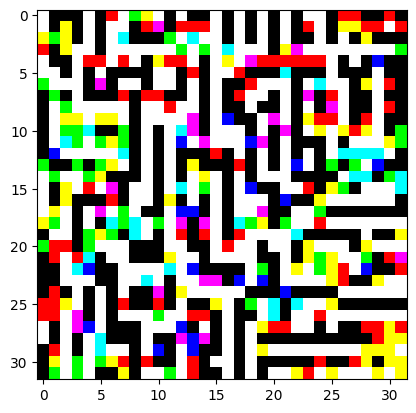

In [20]:
# 敵対的サンプルの表示
plt.imshow(X_test_adv_non_target[target_index])

# 敵対的サンプルに対する推論
pred_adv = classifier.predict(X_test_adv_non_target[target_index][np.newaxis, ...])

# 推論結果の表示
print("### 敵対的サンプルの推論 ###")
print(
    '正解ラベル: "{}"\n予測ラベル: "{}"'.format(
        classes[np.argmax(y_test[target_index])], classes[np.argmax(pred_adv)]
    )
)

In [21]:
# 誤分類させたクラスをOne-hot-vector形式で作成する
# クラス：['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test_targeted = []
for _ in range(len(y_test)):
    # Truck（10番目）をオンにする、上のやつと対応している！　最後Truck
    y_test_targeted.append([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
y_test_targeted = np.array(y_test_targeted)

In [22]:
# FGSMインスタンスの作成（標的型のため、targetedをTrueにする）
#epsがTrueになってる！　標的型になってる！
attack_specific = FastGradientMethod(estimator=classifier, eps=0.05, targeted=True)

In [23]:
# 敵対的サンプルの生成（テストデータを基に作成する）
X_test_adv_target = attack_specific.generate(x=X_test, y=y_test_targeted)

In [24]:
# 敵対的サンプルを使用して標的AIの推論精度を評価
all_preds = classifier.predict(X_test_adv_target)

# 誤分類させたいクラス（標的クラス）に分類された割合を計算
accuracy = np.sum(
    np.argmax(all_preds, axis=1) == np.argmax(y_test_targeted, axis=1)
) / len(y_test_targeted)
print("標的クラス（truck）に分類された割合: {}%".format(accuracy * 100))

標的クラス（truck）に分類された割合: 33.44%


### 正常データの推論 ###
正解ラベル: "automobile"
予測ラベル: "automobile"


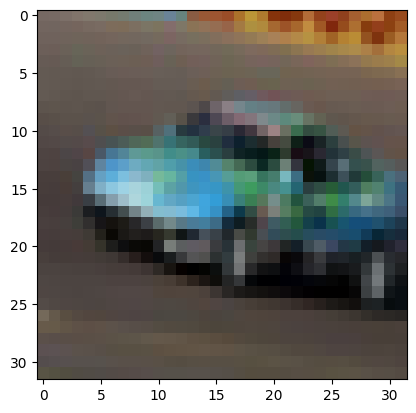

In [25]:
# 正常データの表示
target_index = random.randint(0, len(X_test) - 1)
plt.imshow(X_test[target_index])

# 正常データに対する推論
pred = classifier.predict(X_test[target_index][np.newaxis, ...])

# 推論結果の表示
print("### 正常データの推論 ###")
print(
    '正解ラベル: "{}"\n予測ラベル: "{}"'.format(
        classes[np.argmax(y_test[target_index])], classes[np.argmax(pred)]
    )
)

### 敵対的サンプルの推論 ###
正解ラベル: "automobile"
予測ラベル: "truck"


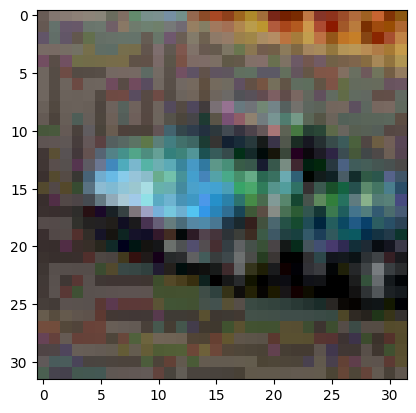

In [26]:
# 敵対的サンプルの表示
plt.imshow(X_test_adv_target[target_index])

# 敵対的サンプルに対する推論
pred_adv = classifier.predict(X_test_adv_target[target_index][np.newaxis, ...])

# 推論結果の表示
print("### 敵対的サンプルの推論 ###")
print(
    '正解ラベル: "{}"\n予測ラベル: "{}"'.format(
        classes[np.argmax(y_test[target_index])], classes[np.argmax(pred_adv)]
    )
)

In [27]:
# Adversarial Training実行前後の推論精度を比較する為、対策前の標的AIをコピー
normal_classifier = copy.deepcopy(classifier)

# Adversarial Trainingインスタンスの作成
defense = AdversarialTrainer(classifier=classifier, attacks=attack_generic, ratio=0.5)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Adversarial Trainingの実行
defense.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epochs=5,
    validation_data=(X_test, y_test),
    shuffle=True,
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
# 【Adversarial Training実行前】の標的AI
# 正常データの推論精度を評価
all_preds = normal_classifier.predict(X_test)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(
    y_test
)
print("### 未対策の標的AI ###")
print("正常データの推論精度   : {}%".format(accuracy * 100))

# 敵対的サンプルの推論精度を評価
all_preds = normal_classifier.predict(X_test_adv_non_target)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(
    y_test
)
print("敵対的サンプルの推論精度 : {}%".format(accuracy * 100))


# 【Adversarial Training実行後】の標的AI
# 正常データの推論精度を評価。
all_preds = defense.predict(X_test)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(
    y_test
)
print("\n### 対策済みの標的AI ###")
print("正常データの推論精度   : {}%".format(accuracy * 100))

# 敵対的サンプルの推論精度を評価
all_preds = defense.predict(X_test_adv_non_target)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(
    y_test
)
print("敵対的サンプルの推論精度 : {}%".format(accuracy * 100))

print("Done.")

### 未対策の標的AI ###
正常データの推論精度   : 79.17%
敵対的サンプルの推論精度 : 10.38%

### 対策済みの標的AI ###
正常データの推論精度   : 81.06%
敵対的サンプルの推論精度 : 52.12%
Done.
